# Food Image Recognition and Calorie Estimation
---

**Problem Statement**
Develop a model that can accurately recognize food items from images and estimate their calorie content, enabling users to track their dietary intake and make informed food choices.

**Dataset**: 
Food-101 Dataset on Kaggle

**Approach**

- Data Loading & Exploration
- Data Preprocessing
- Model Development
- Training & Validation
- Evaluation
- Visualization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
DATA_DIR = 'food-101/food-101/images'

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,          
    validation_split=0.2,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='training',
    seed=42
)


Found 80800 images belonging to 101 classes.


In [9]:
validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 20200 images belonging to 101 classes.


In [11]:
food_names = list(train_generator.class_indices.keys())
num_classes = len(food_names)

print(f"\nFound {train_generator.samples} training images belonging to {num_classes} classes.")
print(f"Found {validation_generator.samples} validation images belonging to {num_classes} classes.")


Found 80800 training images belonging to 101 classes.
Found 20200 validation images belonging to 101 classes.



Visualizing sample images...


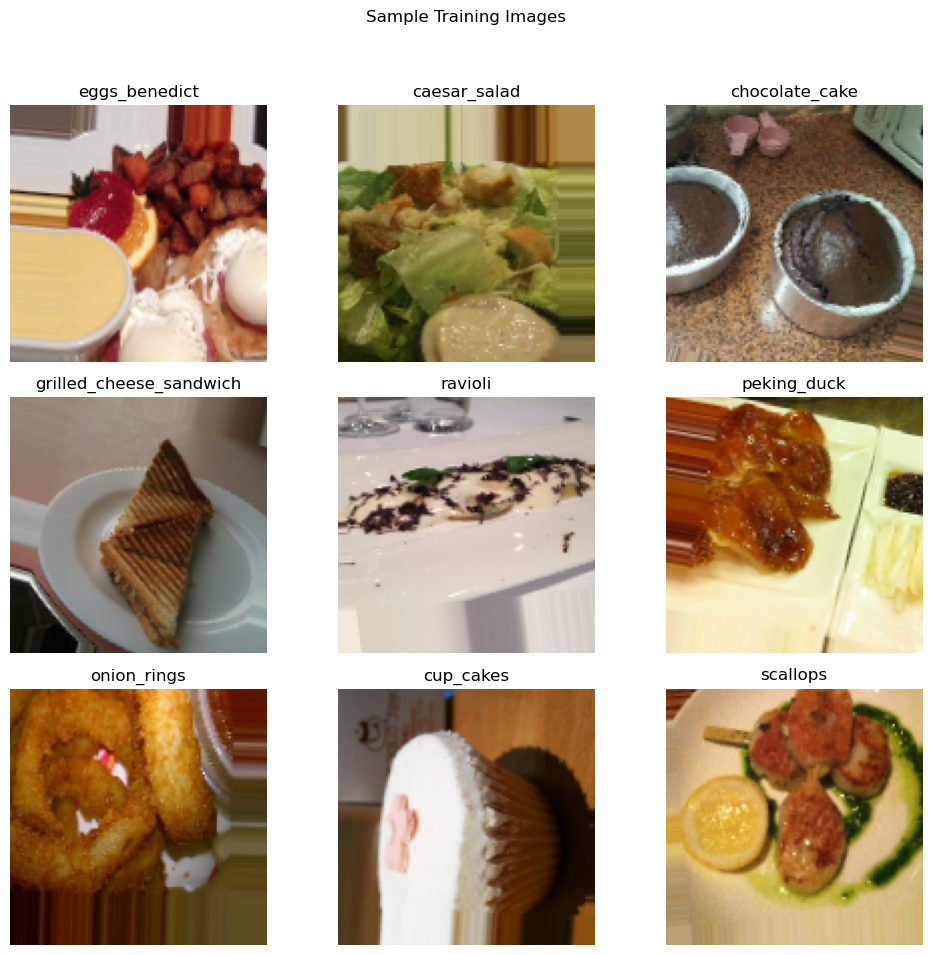

In [13]:
print("\nVisualizing sample images...")
sample_images, sample_labels = next(train_generator) 
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    # Decode one-hot label to class name
    label_idx = np.argmax(sample_labels[i])
    plt.title(food_names[label_idx])
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:
print("\nBuilding CNN Model...")
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Input layer for RGB images
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(num_classes, activation='softmax') # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Building CNN Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,508,069 (32.46 MB)

 Trainable params: 8,508,069 (32.46 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
print("\nTraining Model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=50,  # Use only 50 batches per epoch for fast testing
    validation_data=validation_generator,
    validation_steps=10,
    epochs=20,
    callbacks=[early_stopping],
)


Training Model...
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.0032 - loss: 4.6173 - val_accuracy: 0.0094 - val_loss: 4.6144
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0072 - loss: 4.6165 - val_accuracy: 0.0063 - val_loss: 4.6142
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.0141 - loss: 4.6148 - val_accuracy: 0.0188 - val_loss: 4.6161
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.0066 - loss: 4.6153 - val_accuracy: 0.0250 - val_loss: 4.6149
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0119 - loss: 4.6142 - val_accuracy: 0.0156 - val_loss: 4.6137
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.0112 - loss: 4.6165 - val_accuracy: 0.0031 - val_loss: 4.6166
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0086 - loss: 4.6142 - val_accuracy: 0.0063 - val_loss: 4.6195
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0047 - loss: 4.6162 - val_accuracy:


Visualizing Training History...


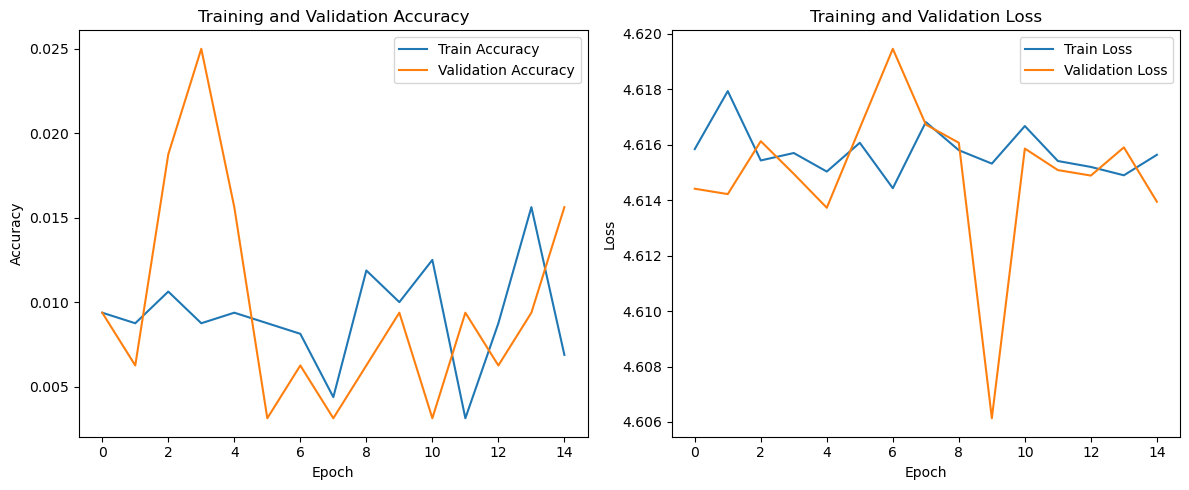

In [33]:
print("\nVisualizing Training History...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()


Evaluating Model on Validation Set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 890ms/step

Generating Confusion Matrix and Classification Report...


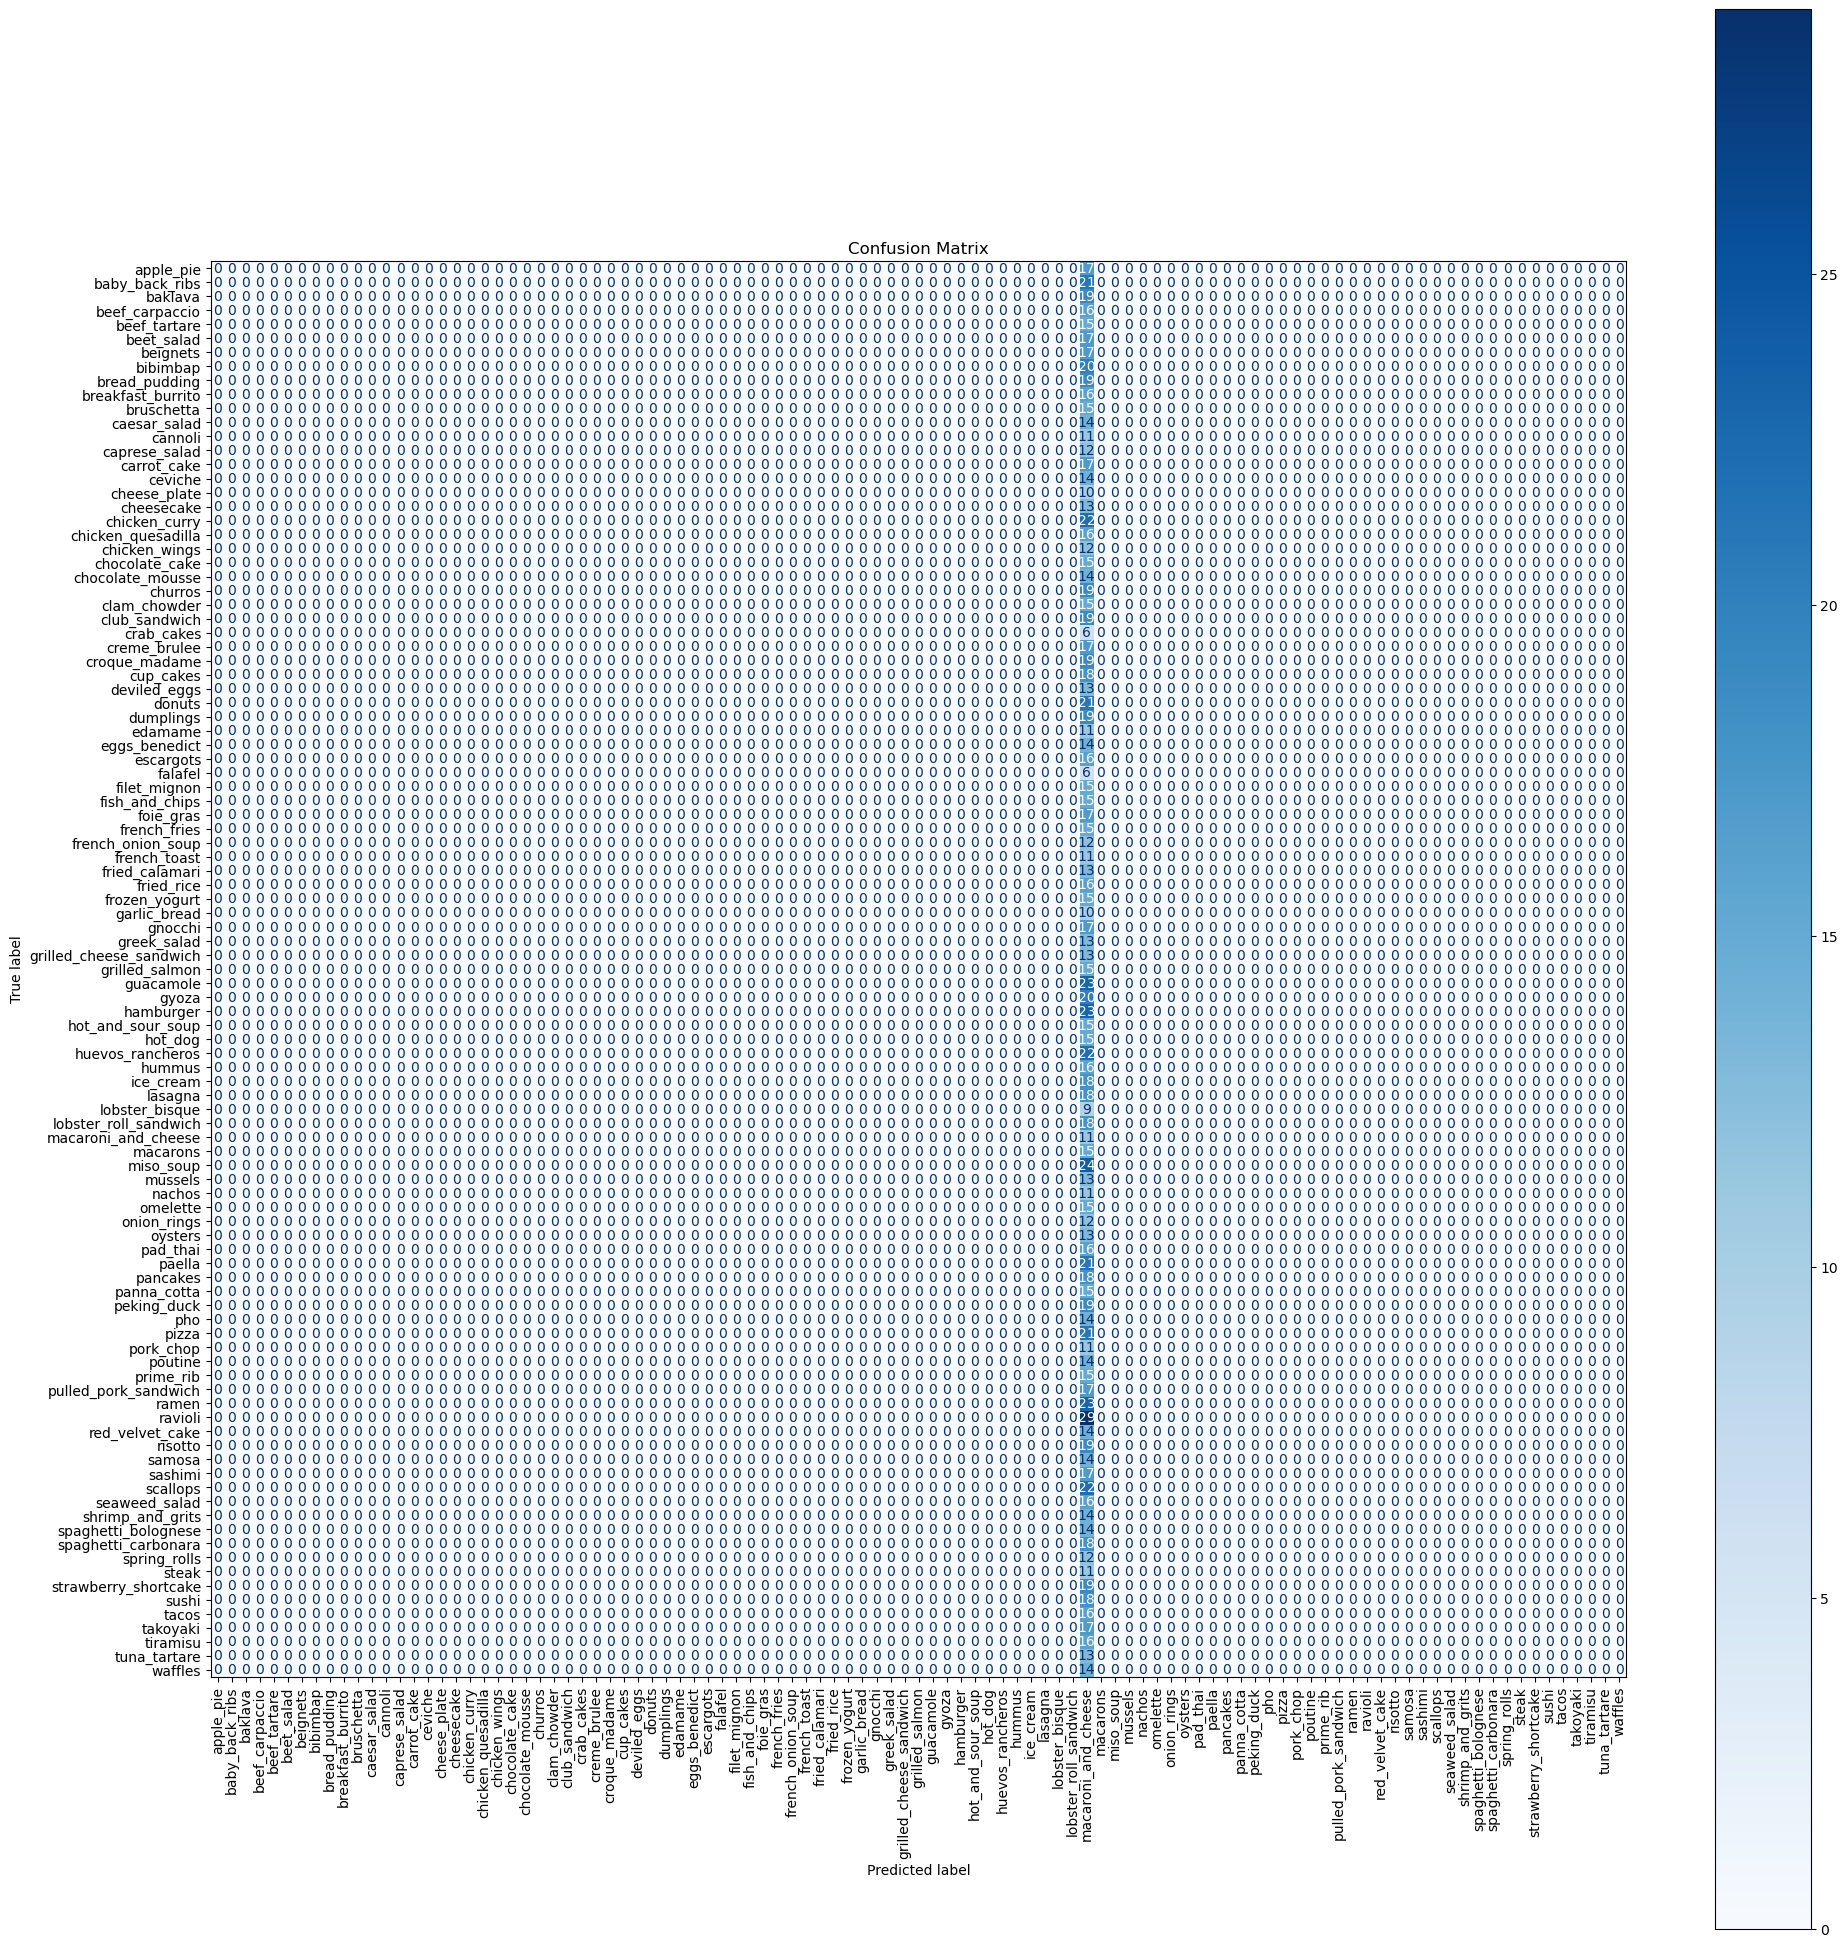


Classification Report:

                         precision    recall  f1-score   support

              apple_pie       0.00      0.00      0.00        17
         baby_back_ribs       0.00      0.00      0.00        21
                baklava       0.00      0.00      0.00        19
         beef_carpaccio       0.00      0.00      0.00        16
           beef_tartare       0.00      0.00      0.00        15
             beet_salad       0.00      0.00      0.00        17
               beignets       0.00      0.00      0.00        17
               bibimbap       0.00      0.00      0.00        20
          bread_pudding       0.00      0.00      0.00        19
      breakfast_burrito       0.00      0.00      0.00        16
             bruschetta       0.00      0.00      0.00        15
           caesar_salad       0.00      0.00      0.00        14
                cannoli       0.00      0.00      0.00        11
          caprese_salad       0.00      0.00      0.00        12

C:\Users\seema\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\seema\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\seema\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
print("\nEvaluating Model on Validation Set...")
validation_generator.reset()
Y_pred_raw = model.predict(validation_generator, steps=50)
y_pred_classes = np.argmax(Y_pred_raw, axis=1)
y_true_classes = validation_generator.classes[validation_generator.index_array]
y_true_classes = y_true_classes[:len(y_pred_classes)]


print("\nGenerating Confusion Matrix and Classification Report...")
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=food_names)
fig, ax = plt.subplots(figsize=(20, 20)) 
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=food_names))


Visualizing Sample Predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


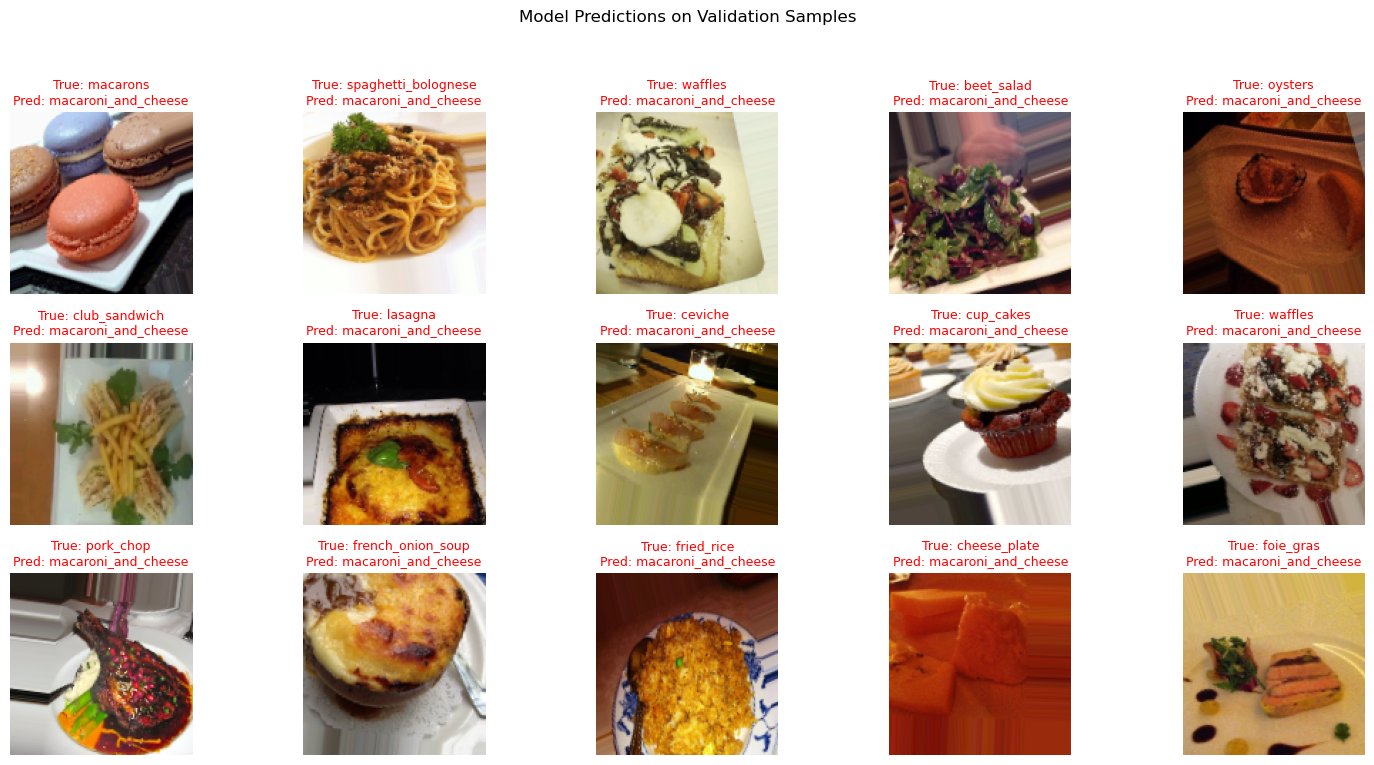


Food Image Recognition project complete!


In [36]:
print("\nVisualizing Sample Predictions...")
plt.figure(figsize=(15, 8))
sample_test_images, sample_test_labels_onehot = next(validation_generator)
sample_test_labels_true_idx = np.argmax(sample_test_labels_onehot, axis=1)
sample_test_predictions = model.predict(sample_test_images)
sample_test_predictions_idx = np.argmax(sample_test_predictions, axis=1)

num_display = min(len(sample_test_images), 15) 
for i in range(num_display):
    plt.subplot(3, 5, i + 1) 
    plt.imshow(sample_test_images[i])
    true_label = food_names[sample_test_labels_true_idx[i]]
    predicted_label = food_names[sample_test_predictions_idx[i]]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=9)
    plt.axis('off')
plt.suptitle('Model Predictions on Validation Samples')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nFood Image Recognition project complete!")

**Conclusion**
--
This pipeline enables you to train a food image classifier and, with calorie mapping, estimate calorie content from images—empowering users to make informed dietary choices